## Introduction

We can make some general observations about Easy21 using simple given policies. 

The initial state of the game is the black card held by the dealer and the black card held by the player.
If the player sticks immediately then there is a chance the dealer will bust with a score lower than 1 or
higher than 21 even if the sum of the dealer's card beats the player's initial card. The dealer's strategy is
independent of the player's strategy and the cards that the player holds.

The player never busts if they stick after the first card. The game can only terminate when the dealer goes bust or
sticks and the likelihood of these events is independent of the player's first card. Therefore the player's win rate is
independent of the player's first card with an always stick strategy.

Suppose that the player always sticks no matter what sum of cards that they hold. The conditional probability of winning the game given this policy and the initial state is shown in the diagram below.

In [1]:
import numpy as np
import environment as env
import plots as plt
e = env.Easy21Environment()
pi = np.full(e.state_size, env.Action.STICK)  # policy to always stick
ave = plt.plot_rewards_dist(e, pi)
print(f'Mean number of wins given policy is {ave * 100:.3f}%')

Mean number of wins given policy is 52.177%


It turns out that this is the (near) optimal policy although this is somewhat obscured in what follows by the random actions in an e-greedy strategy. The policy for when the player's sum is bigger than 10 is irrelevant because it is optimal to stick on the first card so the sum does not progress beyond 10.

Let's try the policy of sticking if the player's sum is 10 or below and hitting if above.

In [2]:
pi = np.empty(e.state_size, dtype=env.Action)
for d in range(1, e.max_initial_dealer_card+1):
    for p in range(1, e.max_player_sum+1):
        if p <= 10:
            pi[d, p] = env.Action.STICK
        else:
            pi[d, p] = env.Action.HIT

In [3]:
ave = plt.plot_rewards_dist(e, pi)
print(f'Mean number of wins given policy is {ave * 100:.3f}%')

Mean number of wins given policy is 52.221%


We see there is little difference in the win rate. It is easy to show by varying the boundary between stick and hit that we cannot do better than the always stick policy.

## 1. Monte-Carlo

The model is first trained using Monte-Carlo. Output is shown in the table below including
the percentage number of wins from the policy.

In [4]:
import mc
model = mc.monte_carlo(num_episodes=100000)
model.df

Episode  Relative_Error  Percent_Wins  MSE
0   10000.0        9.066288     48.285171  NaN
1   20000.0        2.688371     49.127544  NaN
2   30000.0        1.894757     49.551682  NaN
3   40000.0        1.214706     49.956251  NaN
4   50000.0        0.884042     50.182996  NaN
5   60000.0        0.841112     50.374160  NaN
6   70000.0        0.590375     50.664991  NaN
7   80000.0        0.673917     50.864364  NaN
8   90000.0        0.527201     51.030544  NaN
9  100000.0        0.553942     51.141489  NaN

Notice that we have not achieved the win rate of the all stick strategy after 100,000 episodes. The final value function and the optimal policy are shown in the plots below.


In [5]:
import plots as plt
plt.plot_value_policy(model)

We defer using more episodes to the next section because Monte-Carlo is a slow algorithm.

## 2. SARSA($\lambda$)

First we use TD(0) learning to train the model.

In [6]:
import td
model = td.sarsa0(num_episodes=100000)
model.df

Episode  Relative_Error  Percent_Wins  MSE
0   10000.0        8.286277     47.305269  NaN
1   20000.0        2.656804     48.417579  NaN
2   30000.0        1.379389     49.155028  NaN
3   40000.0        0.984592     49.686258  NaN
4   50000.0        0.768617     49.895002  NaN
5   60000.0        0.651830     50.225830  NaN
6   70000.0        0.526743     50.392137  NaN
7   80000.0        0.534003     50.600617  NaN
8   90000.0        0.432869     50.754992  NaN
9  100000.0        0.428114     50.875491  NaN

The plots show the final value function and policy

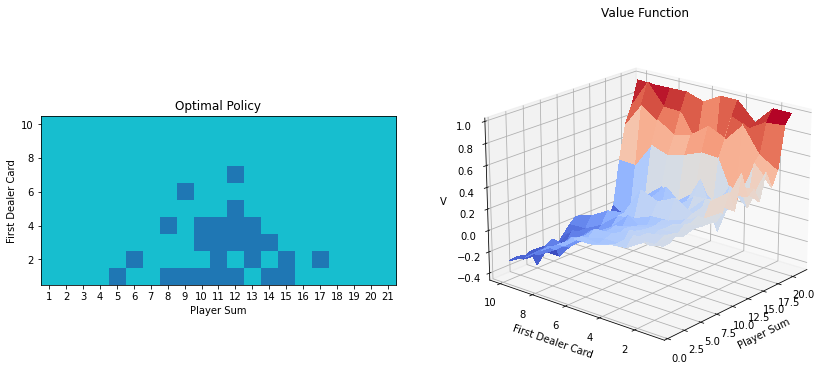

In [7]:
plt.plot_value_policy(model)

With one million episodes we obtain the results below.

In [8]:
model = td.sarsa0(num_episodes=1000000)
plt.plot_value_policy(model)
model.df

Episode  Relative_Error  Percent_Wins  MSE
0     10000.0        8.231267     47.225277  NaN
1     20000.0        2.384456     48.552572  NaN
2     30000.0        1.318238     49.271691  NaN
3     40000.0        1.118280     49.736257  NaN
4     50000.0        0.851116     50.048999  NaN
..        ...             ...           ...  ...
95   960000.0        0.048081     52.097029  NaN
96   970000.0        0.080327     52.102730  NaN
97   980000.0        0.062146     52.096579  NaN
98   990000.0        0.067091     52.109341  NaN
99  1000000.0        0.085797     52.104148  NaN

[100 rows x 4 columns]

This policy still has a few hits when the player's sum is 9 or 10, but we still have not achieved the win rate of the always stick strategy.

## 3. Linear value function approximation

Finally the model is trained using a linear value function approximation and TD learning.
Output from the model training is shown in the table below.

In [9]:
import fa
model = fa.lfa(num_episodes=100000)
model.df

Episode  Relative_Error  Percent_Wins  MSE
0   10000.0        5.180430     51.964804  NaN
1   20000.0        2.018895     52.052397  NaN
2   30000.0        1.861753     52.031599  NaN
3   40000.0        2.716879     51.951201  NaN
4   50000.0        2.315805     51.920962  NaN
5   60000.0        2.272602     51.817470  NaN
6   70000.0        2.502123     51.744975  NaN
7   80000.0        1.678931     51.608105  NaN
8   90000.0        2.868082     51.582760  NaN
9  100000.0        2.499951     51.574484  NaN

In [10]:
plt.plot_value_policy(model)

This policy is closer to the always stick strategy so the win rate is relatively high compared with previous sections for 100,000 episodes.

Even with very high numbers of episodes the linear value function approach cannot yield a higher win rate than the always stick strategy. This is because the always stick strategy cannot be accurately represented given optimal behaviour when the player sum is greater than 10.